In [73]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [74]:
dataset = pd.read_excel('data.xlsx')
regression_dataset = dataset.copy()[["T","Tn","Tx","datetime"]].sort_values("datetime")
tempure_data = regression_dataset[["T","Tn","Tx"]].values.astype(float)

In [75]:
scaler = MinMaxScaler()
tempure_data_scaled = scaler.fit_transform(tempure_data)

In [76]:
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.seq_length]
        target = self.data[idx+self.seq_length][0]  # 预测下一个时间点的温度T
        inputs = torch.tensor(inputs, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        return inputs, target

In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化 hidden state 和 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 前向传播 LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # 将 LSTM 的输出输入到全连接层
        out = self.fc(out[:, -1, :])
        return out

In [78]:
seq_length = 20
input_size = 3  # T, Tn, Tx
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [79]:
train_size = int(len(tempure_data_scaled) * 0.8)
train_data = tempure_data_scaled[:train_size]
test_data = tempure_data_scaled[train_size:]

train_dataset = TemperatureDataset(train_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [81]:
model.train()
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

print("Finished Training")

Epoch [50/50]: 100%|██████████| 182/182 [00:02<00:00, 66.13it/s, loss=0.000822]

Finished Training


In [82]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0009


In [83]:
def predict(model, data, seq_length, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(data) - seq_length):
            inputs = data[i:i+seq_length]
            inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)  # 添加 batch 维度
            output = model(inputs)
            predictions.append(output.item())
    return predictions


In [89]:
test_input = tempure_data_scaled[train_size-seq_length:]
# 进行预测
predicted_values = predict(model, test_input, seq_length, device)

# 反归一化
predicted_values = np.array(predicted_values).reshape(-1, 1)
predicted_values = scaler.inverse_transform(np.concatenate([predicted_values, np.zeros_like(predicted_values), np.zeros_like(predicted_values)], axis=1))[:, 0]

# 真实值
real_values = regression_dataset["T"].values[train_size+seq_length:]

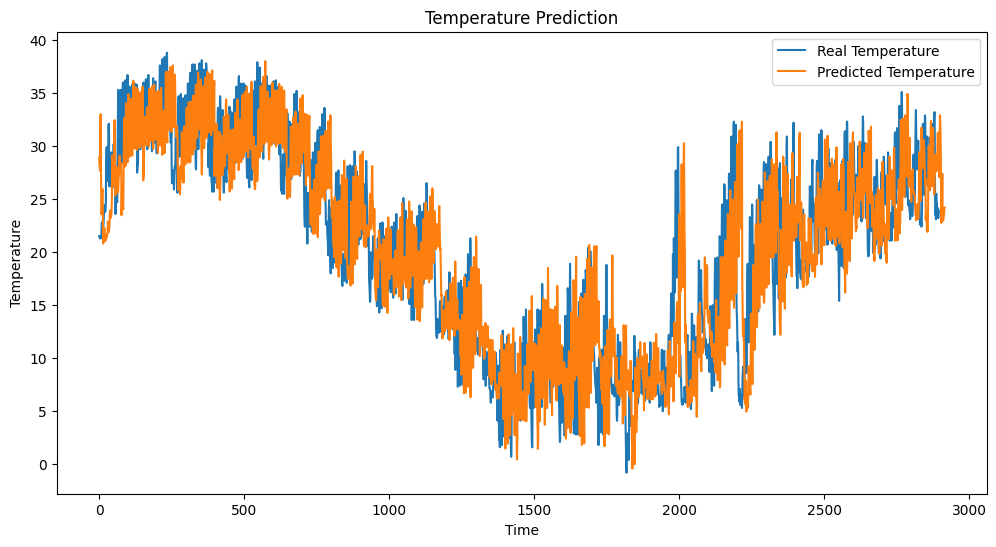

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Real Temperature')
plt.plot(predicted_values, label='Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Prediction')
plt.legend()
plt.show()

In [92]:
# 裁剪 predicted_values 和 real_values 到相同的长度
min_length = min(len(predicted_values), len(real_values))
predicted_values = predicted_values[:min_length]
real_values = real_values[:min_length]

# 计算相对百分误差
relative_percentage_error = np.mean(np.abs((predicted_values - real_values) / real_values)) * 100
print("Relative Percentage Error (RPE): {:.2f}%".format(relative_percentage_error))

# 打印一部分预测结果和实际结果进行对比
num_samples_to_print = 20  # 可以调整这个值来显示更多或更少的样本
print("Predictions vs Real Values (First {} samples):".format(num_samples_to_print))
for i in range(num_samples_to_print):
    error = abs((predicted_values[i] - real_values[i]) / real_values[i]) * 100
    print("Predicted: {:.2f}, Real: {:.2f}, Error: {:.2f}%".format(predicted_values[i], real_values[i], error))

Relative Percentage Error (RPE): 36.04%
Predictions vs Real Values (First 20 samples):
Predicted: 28.92, Real: 21.50, Error: 34.52%
Predicted: 28.30, Real: 21.50, Error: 31.63%
Predicted: 28.04, Real: 21.50, Error: 30.40%
Predicted: 27.66, Real: 21.30, Error: 29.84%
Predicted: 31.08, Real: 21.40, Error: 45.23%
Predicted: 33.01, Real: 21.30, Error: 54.99%
Predicted: 29.15, Real: 21.30, Error: 36.86%
Predicted: 25.41, Real: 21.60, Error: 17.63%
Predicted: 23.57, Real: 21.80, Error: 8.13%
Predicted: 23.94, Real: 22.80, Error: 4.99%
Predicted: 25.47, Real: 22.70, Error: 12.19%
Predicted: 25.97, Real: 22.40, Error: 15.93%
Predicted: 25.77, Real: 22.10, Error: 16.60%
Predicted: 22.14, Real: 22.20, Error: 0.28%
Predicted: 20.81, Real: 22.20, Error: 6.26%
Predicted: 21.05, Real: 22.70, Error: 7.28%
Predicted: 21.22, Real: 23.40, Error: 9.32%
Predicted: 21.77, Real: 24.00, Error: 9.28%
Predicted: 22.28, Real: 24.40, Error: 8.71%
Predicted: 21.51, Real: 24.10, Error: 10.73%
